#Libraries and packages

In [ ]:
!pip install -U scikit-survival
!pip install pysurvival

In [ ]:
import numpy as np
import pandas as pd

from scipy.stats import weibull_min

from sklearn.model_selection import train_test_split

from sksurv.util import Surv
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, brier_score, cumulative_dynamic_auc

from pysurvival.models.semi_parametric import NonLinearCoxPHModel

import time

import matplotlib.pyplot as plt
import seaborn as sns

#Definition of parameters

In [ ]:
lm=.586776e-05
vm=1.333431

lf=6.263214e-06 
vf=1.386246

beta1_m = 0.044*vm
beta2_m = 0.007*vm
beta3_m = 0.003*vm  
beta4_m = -0.011*vm
beta5_m = 0.243*vm
beta6_m = 0.339*vm
beta7_m = 0.134*vm

beta1_f = 0.055*vf
beta2_f = 0.005*vf
beta3_f = 0.002*vf
beta4_f = -0.010*vf
beta5_f = 0.257*vf
beta6_f = 0.482*vf
beta7_f = 0.169*vf

In [ ]:
cindex_coxphf=np.array([])
cindex_coxphm=np.array([])
cindex_svm=np.array([])
cindex_rfsrc=np.array([])
cindex_nonlinear_coxph=np.array([])

MSE_coxphm=np.array([])
MSE_coxphf=np.array([])
MSE_rfsrc=np.array([])
MSE_nonlinear_coxph=np.array([])

In [ ]:
Nsim=100
N=10000

#Simulations

In [ ]:
start=time.time()
for j in range(0, Nsim):
  
  # generate covariate
  x0_gender    = np.random.binomial(n=1, p=0.517, size=N)

  x1_age       = np.where(x0_gender==1, np.random.normal(55.2, 8.65, N), np.random.normal(56.2, 8.43, N)) # continuous integer variable
  x2_sbp       = np.where(x0_gender==1, np.random.normal(134, 13.2, N),  np.random.normal(131, 14.3, N)) # continuous integer variable
  x3_choTOT    = np.where(x0_gender==1, np.random.normal(216, 37.9, N),  np.random.normal(223, 38.7, N)) # continuous integer variable
  x4_choHDL    = np.where(x0_gender==1, np.random.normal(50.8, 12.8, N), np.random.normal(60.8, 15.5, N)) # continuous integer variable
  x5_smoker    = np.where(x0_gender==1, np.random.binomial(n=1, p=0.481, size=N), np.random.binomial(n=1, p=0.291, size=N)) # binary variable
  x6_diabete   = np.where(x0_gender==1, np.random.binomial(n=1, p=0.196, size=N), np.random.binomial(n=1, p=0.143, size=N)) # binary variable
  x7_aitherapy = np.where(x0_gender==1, np.random.binomial(n=1, p=0.343, size=N), np.random.binomial(n=1, p=0.336, size=N)) # binary variable

  x1_age=x1_age.astype(int)
  x2_sbp=x2_sbp.astype(int)
  x3_choTOT=x3_choTOT.astype(int)
  x4_choHDL=x4_choHDL.astype(int)

  # generate censoring times
  t_cens = weibull_min.rvs(9.557882, loc=0, scale=11.502097, size=N)

  # generate observed time and event indicator
  U=np.random.uniform(0, 1, N)
  t_event=  np.where(x0_gender==1,
                (-np.log(U)/(lm*np.exp(beta1_m*x1_age + beta2_m*x2_sbp + beta3_m*x3_choTOT + beta4_m*x4_choHDL + beta5_m*x5_smoker + beta6_m*x6_diabete + beta7_m*x7_aitherapy)))**(1/vm),
                (-np.log(U)/(lf*np.exp(beta1_f*x1_age + beta2_f*x2_sbp + beta3_f*x3_choTOT + beta4_f*x4_choHDL + beta5_f*x5_smoker + beta6_f*x6_diabete + beta7_f*x7_aitherapy)))**(1/vf))

  T_event=np.minimum(t_event, t_cens)
  status=np.where(t_event<t_cens,1,0)

  d = pd.DataFrame()
  d['T_event']=pd.Series(T_event)
  d['t_event']=pd.Series(t_event)
  d['t_cens']=pd.Series(t_cens)
  d['status']=pd.Series(status)
  d['x0_gender']=pd.Series(x0_gender)
  d['x1_age']=pd.Series(x1_age)
  d['x2_sbp']=pd.Series(x2_sbp)
  d['x3_choTOT']=pd.Series(x3_choTOT)
  d['x4_choHDL']=pd.Series(x4_choHDL)
  d['x5_smoker']=pd.Series(x5_smoker)
  d['x6_diabete']=pd.Series(x6_diabete)
  d['x7_aitherapy']=pd.Series(x7_aitherapy)

  X=d[['x0_gender', 'x1_age', 'x2_sbp', 'x3_choTOT', 'x4_choHDL', 'x5_smoker', 'x6_diabete','x7_aitherapy', 't_event']]
  y=d[['status', 'T_event']]

  random_state = j

  X_train, X_test, y_train0, y_test0 = train_test_split(X, y, test_size=0.25, random_state=random_state)

  y_train=Surv.from_dataframe('status', 'T_event', y_train0)
  y_test=Surv.from_dataframe('status', 'T_event', y_test0)

  y_test_S10y=np.where(X_test.x0_gender==1,
                    (np.exp(-lm*10**vm))**(np.exp(beta1_m*X_test.x1_age + beta2_m*X_test.x2_sbp + beta3_m*X_test.x3_choTOT + beta4_m*X_test.x4_choHDL + beta5_m*X_test.x5_smoker + beta6_m*X_test.x6_diabete + beta7_m*X_test.x7_aitherapy)),
                    (np.exp(-lf*10**vf))**(np.exp(beta1_f*X_test.x1_age + beta2_f*X_test.x2_sbp + beta3_f*X_test.x3_choTOT + beta4_f*X_test.x4_choHDL + beta5_f*X_test.x5_smoker + beta6_f*X_test.x6_diabete + beta7_f*X_test.x7_aitherapy)))
  y_test_F10y=1-y_test_S10y
 
  X_trainm=X_train[X_train['x0_gender']==1] 
  X_testm=X_test[X_test['x0_gender']==1] 
  y_trainm=y_train[X_train['x0_gender']==1] 
  y_testm=y_test[X_test['x0_gender']==1]

  X_trainf=X_train[X_train['x0_gender']==0] 
  X_testf=X_test[X_test['x0_gender']==0] 
  y_trainf=y_train[X_train['x0_gender']==0] 
  y_testf=y_test[X_test['x0_gender']==0]

  X_trainm_t_event=X_trainm.t_event
  X_testm_t_event=X_testm.t_event
  X_trainf_t_event=X_trainf.t_event
  X_testf_t_event=X_testf.t_event
  X_train_t_event=X_train.t_event
  X_test_t_event=X_test.t_event


  X_trainm=X_trainm.drop(['x0_gender','t_event'], axis=1)
  X_testm=X_testm.drop(['x0_gender','t_event'], axis=1)
  X_trainf=X_trainf.drop(['x0_gender','t_event'], axis=1)
  X_testf=X_testf.drop(['x0_gender','t_event'], axis=1)

  #odel initialization
  coxphm=CoxPHSurvivalAnalysis()
  coxphf=CoxPHSurvivalAnalysis()

  rsf = RandomSurvivalForest(n_estimators=1000,
                            min_samples_split=10,
                            min_samples_leaf=15,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=0)

  svm = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

  structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]
  nonlinear_coxph = NonLinearCoxPHModel(structure=structure)

  #Cox PH model for gender
  coxphm.fit(X_trainm, y_trainm)

  cindex_coxphm=np.append(cindex_coxphm, concordance_index_censored(np.repeat(np.array([True]), len(y_testm['status'])), X_testm_t_event, coxphm.predict(X_testm))[0])
    
  coxphm_funcs=coxphm.predict_survival_function(X_testm)
  pred_survcoxphm10y=np.array([])
  for fn in coxphm_funcs:
   pred_survcoxphm10y=np.append(pred_survcoxphm10y, fn.y[np.max(np.where(fn.x<=10))])
  MSE_coxphm=np.append(MSE_coxphm, np.mean((y_test_F10y[X_test['x0_gender']==1] - (1-pred_survcoxphm10y))**2))


  coxphf.fit(X_trainf, y_trainf)

  cindex_coxphf=np.append(cindex_coxphf, concordance_index_censored(np.repeat(np.array([True]), len(y_testf['status'])), X_testf_t_event, coxphf.predict(X_testf))[0])

  coxphf_funcs=coxphf.predict_survival_function(X_testf)
  pred_survcoxphf10y=np.array([])
  for fn in coxphf_funcs:
   pred_survcoxphf10y=np.append(pred_survcoxphf10y, fn.y[np.max(np.where(fn.x<=10))])
  MSE_coxphf=np.append(MSE_coxphf, np.mean((y_test_F10y[X_test['x0_gender']==0] - (1-pred_survcoxphf10y))**2))

  X_train.drop(['x0_gender','t_event'], inplace=True, axis=1)
  X_test.drop(['x0_gender','t_event'], inplace=True, axis=1)


  #Random Survival Forest
  rsf.fit(X_train, y_train)
  
  cindex_rfsrc=np.append(cindex_rfsrc, concordance_index_censored(np.repeat(np.array([True]), len(y_test['status'])), X_test_t_event, rsf.predict(X_test))[0])
    
  rfsrc_funcs=rsf.predict_survival_function(X_test)
  pred_survrfsrc10y=np.array([])
  for fn in rfsrc_funcs:
   pred_survrfsrc10y=np.append(pred_survrfsrc10y, fn.y[np.max(np.where(fn.x<=10))])
  MSE_rfsrc=np.append(MSE_rfsrc,np.mean((y_test_F10y - (1-pred_survrfsrc10y))**2))


  #Support Vector Machine
  svm.fit(X_train.astype('float64'), y_train)

  cindex_svm=np.append(cindex_svm, concordance_index_censored(np.repeat(np.array([True]), len(y_test['status'])), X_test_t_event, svm.predict(X_test))[0])

  #Nonlinear CoxPH
  nonlinear_coxph.fit(X_train, y_train0['T_event'], y_train0['status'], lr=1e-3, init_method='xav_uniform')
  pred_survnonlinear_coxph10y=nonlinear_coxph.predict_survival(X_test, t=10)

  cindex_nonlinear_coxph=np.append(cindex_nonlinear_coxph, concordance_index_censored(np.repeat(np.array([True]), len(y_test['status'])), X_test_t_event, nonlinear_coxph.predict_risk(X_test))[0])
  MSE_nonlinear_coxph=np.append(MSE_nonlinear_coxph, np.mean((y_test_F10y - (1-pred_survnonlinear_coxph10y))**2))

  print(j)
end=time.time()

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


In [ ]:
end-start

33154.187264204025

#Performance

In [ ]:
np.mean(cindex_coxphm)

0.6467396156714554

In [ ]:
np.std(cindex_coxphm)

0.011939201846822647

In [ ]:
np.mean(cindex_coxphf)

0.6791820127869691

In [ ]:
np.std(cindex_coxphf)

0.009494898442889617

In [ ]:
np.mean(cindex_svm)

0.6528898471388557

In [ ]:
np.std(cindex_svm)

0.007707651902726136

In [ ]:
np.mean(cindex_rfsrc)

0.6116128515406163

In [ ]:
np.std(cindex_rfsrc)

0.009200511567950037

In [ ]:
np.mean(cindex_nonlinear_coxph)

0.6479686946778712

In [ ]:
np.std(cindex_nonlinear_coxph)

0.008052965985065608

In [ ]:
np.mean(MSE_coxphm)

6.437118168376487e-05

In [ ]:
np.std(MSE_coxphm)

3.8675117344266694e-05

In [ ]:
np.mean(MSE_coxphf)

0.00012030156274016564

In [ ]:
np.std(MSE_coxphf)

7.414346989548923e-05

In [ ]:
np.mean(MSE_rfsrc)

0.00045545096591844526

In [ ]:
np.std(MSE_rfsrc)

5.297427301137726e-05

In [ ]:
np.mean(MSE_nonlinear_coxph)

0.0002923981758310569

In [ ]:
np.std(MSE_nonlinear_coxph)

4.75380780961572e-05

In [ ]:
from google.colab import files

d = pd.DataFrame()
d['cindex_coxphm']=pd.Series(cindex_coxphm)
d['cindex_coxphf']=pd.Series(cindex_coxphf)
d['cindex_svm']=pd.Series(cindex_svm)
d['cindex_rfsrc']=pd.Series(cindex_rfsrc)
d['cindex_nonlinear_coxph']=pd.Series(cindex_nonlinear_coxph)

d['MSE_coxphm']=pd.Series(MSE_coxphm)
d['MSE_coxphf']=pd.Series(MSE_coxphf)
d['MSE_svm']=pd.Series(MSE_coxphf)
d['MSE_rfsrc']=pd.Series(MSE_coxphf)
d['MSE_nonlinear_coxph']=pd.Series(MSE_coxphf)

d.to_csv('output_sim.csv', encoding = 'utf-8-sig') 
files.download('output_sim.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Graphs

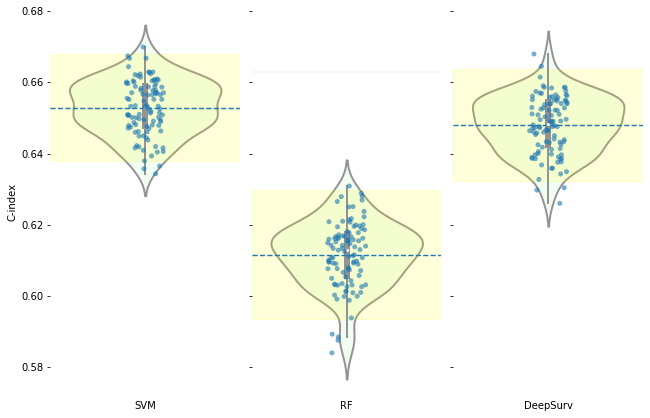

In [ ]:
#C-index
fig, axes = plt.subplots(1, 3, figsize=(9, 6), sharey=True)
fig.tight_layout(w_pad=-1)
axes[1].axhline(np.mean(np.concatenate((cindex_coxphm, cindex_coxphf))), color='tab:red', lw=0.1, ls='-')

# svm
sns.violinplot(ax=axes[0], y=cindex_svm, color="honeydew",linewidth=2)
sns.stripplot(ax=axes[0], y=cindex_svm, jitter=True, alpha=0.6)
axes[0].axhline(np.mean(cindex_svm), color='tab:blue', lw=1.4, ls='--')
axes[0].axhspan(np.mean(cindex_svm)-1.96*np.std(cindex_svm),np.mean(cindex_svm)+1.96*np.std(cindex_svm), alpha=0.15, color='yellow')
axes[0].set_xlabel('SVM')
axes[0].set_ylabel('C-index')
axes[0].set(frame_on=False, xticks=())

# rsf
sns.violinplot(ax=axes[1], y=cindex_rfsrc, color="honeydew",linewidth=2)
sns.stripplot(ax=axes[1], y=cindex_rfsrc, jitter=True, alpha=0.6)
axes[1].axhline(np.mean(cindex_rfsrc), color='tab:blue', lw=1.4, ls='--')
axes[1].axhspan(np.mean(cindex_rfsrc)-1.96*np.std(cindex_rfsrc),np.mean(cindex_rfsrc)+1.96*np.std(cindex_rfsrc), alpha=0.15, color='yellow')
axes[1].set_xlabel('RF')
axes[1].set(frame_on=False, xticks=());

# nonlinear_coxph
sns.violinplot(ax=axes[2], y=cindex_nonlinear_coxph, color="honeydew",linewidth=2)
sns.stripplot(ax=axes[2], y=cindex_nonlinear_coxph, jitter=True, alpha=0.6)
axes[2].axhline(np.mean(cindex_nonlinear_coxph), color='tab:blue', lw=1.4, ls='--')
axes[2].axhspan(np.mean(cindex_nonlinear_coxph)-1.96*np.std(cindex_nonlinear_coxph),np.mean(cindex_nonlinear_coxph)+1.96*np.std(cindex_nonlinear_coxph), alpha=0.15, color='yellow')
axes[2].set_xlabel('DeepSurv')
axes[2].set(frame_on=False, xticks=());

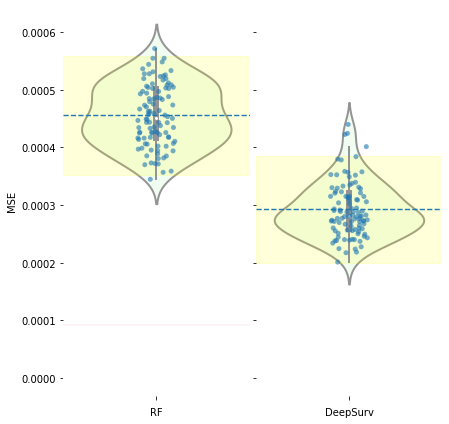

In [ ]:
#MSE
fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)
fig.tight_layout(w_pad=-1)
axes[0].axhline(np.mean(np.concatenate((MSE_coxphm, MSE_coxphf))), color='tab:red', lw=0.1, ls='-')
axes[0].axhline(0, color='white', lw=1.4, ls='-')

# rsf
sns.violinplot(ax=axes[0], y=MSE_rfsrc, color="honeydew",linewidth=2)
sns.stripplot(ax=axes[0], y=MSE_rfsrc, jitter=True, alpha=0.6)
axes[0].axhline(np.mean(MSE_rfsrc), color='tab:blue', lw=1.4, ls='--')
axes[0].axhspan(np.mean(MSE_rfsrc)-1.96*np.std(MSE_rfsrc),np.mean(MSE_rfsrc)+1.96*np.std(MSE_rfsrc), alpha=0.15, color='yellow')
axes[0].set_xlabel('RF')
axes[0].set_ylabel('MSE')
axes[0].set(frame_on=False);

# nonlinear_coxph
sns.violinplot(ax=axes[1], y=MSE_nonlinear_coxph, color="honeydew",linewidth=2)
sns.stripplot(ax=axes[1], y=MSE_nonlinear_coxph, jitter=True, alpha=0.6)
axes[1].axhline(np.mean(MSE_nonlinear_coxph), color='tab:blue', lw=1.4, ls='--')
axes[1].axhspan(np.mean(MSE_nonlinear_coxph)-1.96*np.std(MSE_nonlinear_coxph),np.mean(MSE_nonlinear_coxph)+1.96*np.std(MSE_nonlinear_coxph), alpha=0.15, color='yellow')
axes[1].set_xlabel('DeepSurv')
axes[1].set(frame_on=False);